# Project Description

# Part 1: Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv('KAG_energydata_complete.csv', index_col=0)
print(df.shape)
print(df.columns)
print(df.head(10))
df.info()

(19735, 28)
Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')
                     Appliances  lights         T1       RH_1     T2  \
date                                                                   
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.20   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.20   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.20   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.20   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.20   
2016-01-11 17:50:00          50      40  19.890000  46.026667  19.20   
2016-01-11 18:00:00          60      50  19.890000  45.766667  19.20   
2016-01-11 18:10:00          60      50  19.856667 

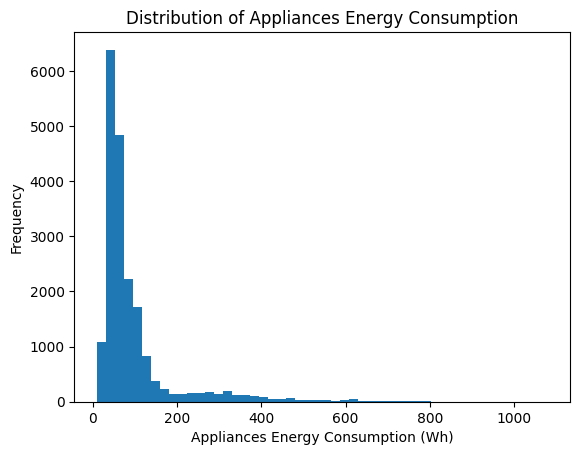

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['Appliances'], bins=50)
plt.xlabel('Appliances Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.title('Distribution of Appliances Energy Consumption')
plt.show()

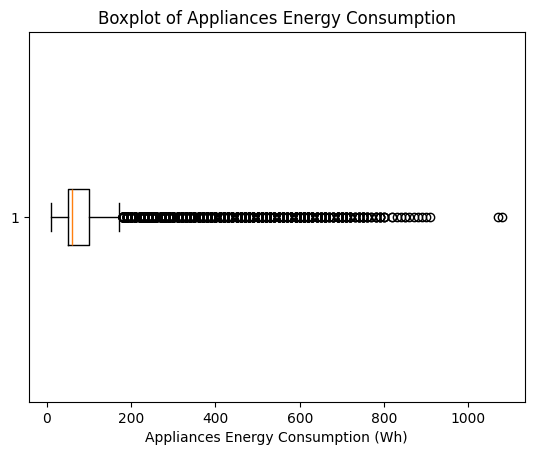

In [3]:
plt.figure()
plt.boxplot(df['Appliances'], vert=False)
plt.xlabel('Appliances Energy Consumption (Wh)')
plt.title('Boxplot of Appliances Energy Consumption')
plt.show()

According to the plots, the target variable exhibits a large number of extreme values, indicating the presence of high energy consumption spikes that should be explicitly considered in the modeling process.

# Part 2: Feature Engineering

## 1. Time features

In [39]:
import numpy as np

In [40]:
df = df.copy()
df.index = pd.to_datetime(df.index)

In [41]:
# extract basic time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.dayofyear

In [42]:
# weekend or not
df['is_weekend'] = np.where(df.index.dayofweek >= 5, 'weekend', 'weekday')

In [43]:
conditions = [
    (df['hour'] >= 6) & (df['hour'] < 12),
    (df['hour'] >= 12) & (df['hour'] < 18),
    (df['hour'] >= 18) & (df['hour'] < 24)
]

choices = ['morning', 'afternoon', 'evening']

df['time_period'] = np.select(conditions, choices, default='night')


In [44]:
# to encode periodic time features

"""
In order to capture periodic patterns, we apply cyclical encoding using sine and cosine transformations. 
This converts discrete time units into continuous circular coordinates.
It maintains the proximity between adjacent periods and eliminating artificial discontinuities at period boundaries.

"""

# hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# day of month
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 30)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 30)

# day of year
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 366)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 366)

## 2. Temperature features

In [45]:
df["T_indoor_avg"] = df[df.filter(like='T').columns.drop('T6','T_out')].mean(axis=1) # average temperature of 8 rooms
df["T_indoor_std"] = df[df.filter(like='T').columns.drop('T6','T_out')].std(axis=1) # standard error of temperature of 8 rooms
df["T_indoor_max"] = df[df.filter(like='T').columns.drop('T6','T_out')].max(axis=1) # maximum temperature of 8 rooms
df["T_indoor_min"] = df[df.filter(like='T').columns.drop('T6','T_out')].min(axis=1) # minimum temperature of 8 rooms
df["T_indoor_range"] = df["T_indoor_max"] - df["T_indoor_min"] # the range of indoor temperature
df['T_indoor_change'] = df['T_indoor_avg'].diff() # change rate of indoor temperature

In [46]:
# the difference between indoor and outdoor temperatures
df["T_diff_1"] = df["T_indoor_avg"] - df["T6"]
df["T_diff_2"] = df["T_indoor_avg"] - df["T_out"]

## 3. Humidity features

In [47]:
df["RH_indoor_avg"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].mean(axis=1) # average humidity of 8 rooms
df["RH_indoor_std"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].std(axis=1) # standard error of humidity of 8 rooms
df["RH_indoor_max"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].max(axis=1) # maximum humidity of 8 rooms
df["RH_indoor_min"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].min(axis=1) # minimum humidity of 8 rooms
df["RH_indoor_range"] = df["RH_indoor_max"] - df["RH_indoor_min"] # the range of indoor humidity
df['RH_indoor_change'] = df['RH_indoor_avg'].diff() # change rate of indoor humidity

In [48]:
# the difference between indoor and outdoor humidity
df["RH_diff_1"] = df["RH_indoor_avg"] - df["RH_6"]
df["RH_diff_2"] = df["RH_indoor_avg"] - df["RH_out"]

In [49]:
pip install metpy

Note: you may need to restart the kernel to use updated packages.


In [50]:
# comfort measures
import metpy.calc as mpcalc
from metpy.calc import heat_index
from metpy.units import units
temp = df["T_indoor_avg"].values * units.degC
humidity = df["RH_indoor_avg"].values * units.percent

# heat index
df["heat_index"] = heat_index(temp, humidity)

# dewpoint
df["dewpoint"] = mpcalc.dewpoint_from_relative_humidity(temp, humidity)

## 4. Weather measures

In [51]:
# weather comprehensive measure
df["weather_com"] = df["T_out"].values * df["RH_out"].values *0.01 * df["Windspeed"].values

In [52]:
# change rate
df['T6_change'] = df['T6'].diff()
df['T_out_change'] = df['T_out'].diff()
df['RH_6_change'] = df['RH_6'].diff()
df['RH_out_change'] = df['RH_out'].diff()
df['Press_change'] = df['Press_mm_hg'].diff()
df['Windspeed_change'] = df['Windspeed'].diff()

## 5. Lag features (without target)

In [53]:
# lights lag
df['lights_lag1'] = df['lights'].shift(1)  
df['lights_lag2'] = df['lights'].shift(2)  
df['lights_lag3'] = df['lights'].shift(3)
df['lights_lag4'] = df['lights'].shift(6)
df['lights_lag5'] = df['lights'].shift(144)

In [54]:
# weather lag
df['T_indoor_lag1'] = df['T_indoor_avg'].shift(1)
df['T_indoor_lag6'] = df['T_indoor_avg'].shift(6)

df['T_out_lag1'] = df['T_out'].shift(1)
df['T_out_lag6'] = df['T_out'].shift(6)

## 6. Rolling features (without target)

In [55]:
# lights rolling
df['lights_rolling_mean_3'] = df['lights'].rolling(window=3, min_periods=1).mean()
df['lights_rolling_mean_6'] = df['lights'].rolling(window=6, min_periods=1).mean()
df['lights_rolling_mean_12'] = df['lights'].rolling(window=12, min_periods=1).mean()
df['lights_rolling_mean_18'] = df['lights'].rolling(window=18, min_periods=1).mean()
df['lights_rolling_max_6'] = df['lights'].rolling(window=6, min_periods=1).max()
df['lights_rolling_min_6'] = df['lights'].rolling(window=6, min_periods=1).min()
df['lights_rolling_std_18'] = df['lights'].rolling(window=18, min_periods=1).std()
df['lights_rolling_std_36'] = df['lights'].rolling(window=36, min_periods=1).std()

In [56]:
# weather rolling
df['T_indoor_rolling_mean_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).mean()
df['T_indoor_rolling_max_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).max()
df['T_indoor_rolling_min_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).min()
df['T_indoor_rolling_std_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).std()

df['T_out_rolling_mean_6'] = df['T_out'].rolling(window=6, min_periods=1).mean()
df['T_out_rolling_std_6'] = df['T_out'].rolling(window=6, min_periods=1).std()

## 7. Target variable rolling/lag

In [57]:
# split train and test dataset
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Appliances"]) 
y = np.log1p(df["Appliances"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [58]:
# appliance lag
target_col = 'Appliances'

X_train[f'{target_col}_lag1']   = y_train.shift(1)
X_train[f'{target_col}_lag2']   = y_train.shift(2)
X_train[f'{target_col}_lag3']   = y_train.shift(3)
X_train[f'{target_col}_lag6']   = y_train.shift(6)
X_train[f'{target_col}_lag144'] = y_train.shift(144)

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

In [59]:
# appliance rolling
X_train[f'{target_col}_rolling_mean_3']  = y_train.rolling(3,  min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_6']  = y_train.rolling(6,  min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_12'] = y_train.rolling(12, min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_18'] = y_train.rolling(18, min_periods=1).mean().shift(1)

X_train[f'{target_col}_rolling_max_6'] = y_train.rolling(6, min_periods=1).max().shift(1)
X_train[f'{target_col}_rolling_min_6'] = y_train.rolling(6, min_periods=1).min().shift(1)

X_train[f'{target_col}_rolling_std_18'] = y_train.rolling(18, min_periods=1).std().shift(1)
X_train[f'{target_col}_rolling_std_36'] = y_train.rolling(36, min_periods=1).std().shift(1)

X_train[f'{target_col}_rolling_range_6'] = (
    y_train.rolling(6, min_periods=1).max()
    - y_train.rolling(6, min_periods=1).min()
).shift(1)

X_train[f'{target_col}_diff_1'] = y_train.diff(1).shift(1)

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# Part 3: Feature Analysis

In [60]:
train_df = X_train.copy()
train_df["Appliances"] = y_train

In [62]:
# correlation-based feature selection
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numeric_cols].corr()
corr_with_target = corr_matrix[target_col].drop(target_col, errors='ignore')

k = 60
top_k = corr_with_target.abs().sort_values(ascending=False)[:k].index

selected_target_corr = corr_with_target[top_k].sort_values(ascending=False)
for i, (feature, corr) in enumerate(selected_target_corr.items(), 1):
    sign = "+" if corr > 0 else "-"
    print(f"{i:2d}. {feature:35s}: {corr:7.4f} ({sign})")

 1. Appliances_lag1                    :  0.8335 (+)
 2. Appliances_rolling_mean_3          :  0.7697 (+)
 3. Appliances_rolling_mean_6          :  0.7206 (+)
 4. Appliances_rolling_max_6           :  0.7188 (+)
 5. Appliances_lag2                    :  0.6988 (+)
 6. Appliances_rolling_mean_12         :  0.6810 (+)
 7. Appliances_rolling_mean_18         :  0.6317 (+)
 8. Appliances_rolling_min_6           :  0.6190 (+)
 9. Appliances_lag3                    :  0.6078 (+)
10. Appliances_lag6                    :  0.5039 (+)
11. Appliances_rolling_std_18          :  0.4760 (+)
12. Appliances_rolling_range_6         :  0.4106 (+)
13. Appliances_rolling_std_36          :  0.3818 (+)
14. Appliances_lag144                  :  0.3564 (+)
15. lights_rolling_max_6               :  0.3113 (+)
16. lights_rolling_mean_3              :  0.3018 (+)
17. lights                             :  0.2891 (+)
18. T_indoor_change                    :  0.2866 (+)
19. lights_rolling_mean_6              :  0.28

1. The strong correlation between the target variable and its lagged and rolling statistics indicates autocorrelation, which is consistent with the persistent nature of residential appliance usage.  
2. "Lights" feature is a behavorial proxy rather than a main driver as its correlation score is not high.

In [63]:
# Bottom correlation features
all_correlations = corr_with_target.abs().sort_values(ascending=False)
print(all_correlations.tail(20))

T_indoor_min        0.057467
T_indoor_std        0.052362
day_of_year_cos     0.052351
day_of_month_sin    0.051309
RH_indoor_change    0.049267
Windspeed_change    0.046524
Tdewpoint           0.046503
day_of_week_cos     0.042644
dewpoint            0.037883
day_of_week_sin     0.033620
T6_change           0.030296
RH_4                0.024503
RH_out_change       0.022406
RH_6_change         0.019527
Visibility          0.014546
RH_5                0.011519
T_out_change        0.008044
rv2                 0.005528
rv1                 0.005528
RH_3                0.001637
Name: Appliances, dtype: float64


AS the correlation results between rv1/rv2 and the target are approximately zero, we can delete these two random variables.

In [64]:
X_train = X_train.drop(columns=["rv1","rv2"]) 

# Part 4: Train model

## Catboost

In [65]:
import re

In [66]:
all_features = X_train.columns  

feature_categories = {
    'Lights': [f for f in all_features if 'lights' in f],

    'Appliances': [f for f in all_features if f.startswith('Appliances_')],

    'Indoor': [
        f for f in all_features
        if (
        (
            f.startswith('T_indoor')
            or f.startswith('RH_indoor')
            or re.fullmatch(r'T\d+', f)         
            or re.fullmatch(r'RH_\d+', f)        
            or f == 'dewpoint'
        )
        and f not in ['T6', 'RH_6']
        and ('rolling' not in f and 'lag' not in f)
    )
    ],

    'Outdoor/Weather': [
        f for f in all_features if f in [
            'T_out', 'RH_out', 'Press_mm_hg', 'Press_change',
            'Windspeed', 'Windspeed_change', 'Visibility',
            'Tdewpoint', 'heat_index', 'weather_com'
        ]
    ],

    'Time': [
        f for f in all_features if f in [
            'hour', 'day_of_week', 'month', 'day_of_month', 'day_of_year',
            'is_weekend', 'time_period',
            'hour_sin', 'hour_cos',
            'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',
            'day_of_month_sin', 'day_of_month_cos',
            'day_of_year_sin', 'day_of_year_cos'
        ]
    ],

    'lagging/rolling': [
        f for f in all_features
        if (
            ('lag' in f or 'rolling' in f)
            and not f.startswith('Appliances_')
            and 'lights' not in f
        )
    ]
}

outdoor_features = [
    'T6', 'RH_6',
    'T_diff_1', 'T_diff_2',
    'RH_diff_1', 'RH_diff_2',
    'T_out_change', 'T6_change',
    'RH_6_change', 'RH_out_change'
]

feature_categories['Outdoor/Weather'].extend(
    [f for f in outdoor_features if f in all_features]
)

for cat, feats in feature_categories.items():
    print(f"{cat}: {len(feats)} features")


Lights: 14 features
Appliances: 15 features
Indoor: 29 features
Outdoor/Weather: 20 features
Time: 17 features
lagging/rolling: 10 features


In [67]:
from catboost import CatBoostRegressor

In [ ]:
cat_features = ['is_weekend', 'time_period']

model_cat = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)
model_cat.fit(X_train, y_train)

In [449]:
#select features using feature importance
selected_features_by_category = {}
all_selected_features_set = set()

for group_name, features in feature_categories.items():
    num_to_select = max(1, len(features) // 2)  
    selected = model_cat.select_features(
        X=X_train,
        y=y_train,
        features_for_select=features,
        num_features_to_select=num_to_select,  
        algorithm='RecursiveByShapValues',
        steps=4,
        train_final_model=False,
        logging_level='Silent'
    )

    unique_feats = [f for f in selected['selected_features'] if f not in all_selected_features_set]
    selected_features_by_category[group_name] = unique_feats
    all_selected_features_set.update(unique_feats)

selected_features_by_category_names = {}
for category, feats in selected_features_by_category.items():
    feat_names = [X_train.columns[f] if isinstance(f, int) else f for f in feats]
    selected_features_by_category_names[category] = feat_names

for category, feat_names in selected_features_by_category_names.items():
    print(f"{category}: {feat_names}")

Lights: ['lights', 'lights_rolling_mean_12', 'lights_lag5', 'lights_rolling_mean_18', 'lights_rolling_min_6', 'lights_rolling_std_18', 'lights_rolling_std_36']
Appliances: ['Appliances_lag1', 'Appliances_lag2', 'Appliances_rolling_std_18', 'Appliances_rolling_range_6', 'Appliances_diff_1', 'Appliances_rolling_mean_3', 'Appliances_rolling_mean_12']
Indoor: ['RH_indoor_avg', 'RH_indoor_std', 'RH_indoor_change', 'dewpoint', 'T_indoor_max', 'T_indoor_change']
Outdoor/Weather: ['T6', 'Press_mm_hg', 'Visibility', 'RH_diff_1', 'RH_diff_2', 'T_out_change', 'T6_change', 'RH_6_change', 'RH_out_change', 'Press_change']
Time: ['hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour', 'day_of_year', 'hour_sin']
lagging/rolling: ['T_indoor_rolling_std_6', 'T_out_rolling_std_6', 'T_indoor_lag6', 'T_out_lag1', 'T_out_lag6']


In [450]:
selected_feature_names_cat = []
for feat_names in selected_features_by_category_names.values():
    selected_feature_names_cat.extend(feat_names)
    
X_train_selected_features = X_train[selected_feature_names_cat]
model_cat.fit(X_train_selected_features, y_train)

In [451]:
# final feature selection using permutation importance
# calculate pfi
from sklearn.inspection import permutation_importance
pfi_result = permutation_importance(
    model_cat, 
    X_train_selected_features, 
    y_train, 
    n_repeats=10,  
    random_state=42,
    scoring='neg_root_mean_squared_error'  
)
feature_importance_df = pd.DataFrame({
    'feature': X_train_selected_features.columns,
    'importance': pfi_result.importances_mean
}).sort_values(by='importance', ascending=False)


In [452]:
# PFI importance ranking by category
pfi_by_category = {}

for category, feat_names in selected_features_by_category_names.items():
    df_cat = feature_importance_df[
        feature_importance_df['feature'].isin(feat_names)
    ].sort_values(by='importance', ascending=False)

    pfi_by_category[category] = df_cat

In [453]:
final_features_by_category = {}
used_features = set()

# assign one feature for each category
for category, df_cat in pfi_by_category.items():
    f = df_cat.iloc[0]['feature']
    final_features_by_category[category] = [f]
    used_features.add(f)



In [633]:
MAX_FEATURES = 23
current_count = len(used_features)

remaining_df = feature_importance_df[
    ~feature_importance_df['feature'].isin(used_features)
]

for _, row in remaining_df.iterrows():
    if current_count >= MAX_FEATURES:
        break

    feature = row['feature']

    for category, feat_list in selected_features_by_category_names.items():
        if feature in feat_list:
            final_features_by_category[category].append(feature)
            used_features.add(feature)
            current_count += 1
            break


In [634]:
for category, feats in final_features_by_category.items():
    print(f"{category} ({len(feats)}):")
    for f in feats:
        print(f"  - {f}")


Lights (1):
  - lights
Appliances (7):
  - Appliances_lag1
  - Appliances_diff_1
  - Appliances_rolling_mean_3
  - Appliances_rolling_mean_12
  - Appliances_lag2
  - Appliances_rolling_range_6
  - Appliances_rolling_std_18
Indoor (5):
  - RH_indoor_change
  - T_indoor_change
  - T_indoor_max
  - dewpoint
  - RH_indoor_std
Outdoor/Weather (5):
  - T6
  - RH_diff_1
  - Visibility
  - T6_change
  - RH_6_change
Time (2):
  - hour_sin
  - hour_cos
lagging/rolling (3):
  - T_indoor_lag6
  - T_indoor_rolling_std_6
  - T_out_rolling_std_6


In [635]:
final_feature_names = []
for feats in final_features_by_category.values():
    final_feature_names.extend(feats)


In [636]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [637]:
T_out_thresh = df['T_out_change'].abs().quantile(0.75)
RH_out_thresh = df['RH_out_change'].abs().quantile(0.75)
T6_thresh = df['T6_change'].abs().quantile(0.75)
RH_6_thresh = df['RH_6_change'].abs().quantile(0.75)

is_spike = (df['T_out_change'].abs() > T_out_thresh) | (df['RH_out_change'].abs() > RH_out_thresh) | (df['T6_change'].abs() > T6_thresh) | (df['RH_6_change'].abs() > RH_6_thresh)


In [ ]:
print(T_out_thresh)
print(RH_out_thresh)
print(T6_thresh)
print(RH_6_thresh)

330.0
0.1666666666666572
0.8333333333333997
0.1366666666667058
0.8104687500000018


In [638]:
final_feature_names.extend(['T_out_change', 'RH_out_change'])

In [639]:
X_train_final = X_train[final_feature_names]

### Normal period training

In [640]:
X_train_normal = X_train_final[~is_spike]
y_train_normal = y_train[~is_spike]

C:\Users\hp\AppData\Local\Temp\ipykernel_14408\4006012422.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_normal = X_train_final[~is_spike]


In [641]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [300, 500],
}


In [642]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_normal, y_train_normal)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023658467EC0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [300, 500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error')

In [643]:
print("Best RMSE (CV):", -grid_search.best_score_)
print("Best parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_


Best RMSE (CV): 53.19742866414549
Best parameters:
{'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.03}


In [644]:
# using final selected features and best params on test dataset
best_params_normal = {
    'depth': 6,
    'iterations': 300,
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 0
}

model_normal = CatBoostRegressor(**best_params_normal)
model_normal.fit(X_train_normal, y_train_normal)

### High spike training

In [645]:
X_train_spike = X_train_final[is_spike]
y_train_spike = y_train[is_spike]
y_train_spike_clipped = y_train_spike.clip(upper=1000)
y_train_spike_log = np.log1p(y_train_spike_clipped)

C:\Users\hp\AppData\Local\Temp\ipykernel_14408\1307128297.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_spike = X_train_final[is_spike]


In [646]:
X_train_spike['stage1_pred'] = model_normal.predict(X_train_spike)

C:\Users\hp\AppData\Local\Temp\ipykernel_14408\1863168997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_spike['stage1_pred'] = model_normal.predict(X_train_spike)


In [647]:
X_train_spike[f'{target_col}_rolling_max_6'] = df[f'{target_col}_rolling_max_6']
X_train_spike[f'{target_col}_lag3'] = df[f'{target_col}_lag3']
X_train_spike[f'{target_col}_lag6'] = df[f'{target_col}_lag6'] 
X_train_spike[f'{target_col}_lag144'] = df[f'{target_col}_lag144']
X_train_spike[f'{target_col}_rolling_mean_6'] = df[f'{target_col}_rolling_mean_6']
X_train_spike[f'{target_col}_rolling_mean_18'] = df[f'{target_col}_rolling_mean_18']
X_train_spike[f'{target_col}_rolling_std_36'] = df[f'{target_col}_rolling_std_36'] 


C:\Users\hp\AppData\Local\Temp\ipykernel_14408\2154403797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_spike[f'{target_col}_rolling_max_6'] = df[f'{target_col}_rolling_max_6']
C:\Users\hp\AppData\Local\Temp\ipykernel_14408\2154403797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_spike[f'{target_col}_lag3'] = df[f'{target_col}_lag3']
C:\Users\hp\AppData\Local\Temp\ipykernel_14408\2154403797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [648]:
X_train_spike.columns

Index(['lights', 'Appliances_lag1', 'Appliances_diff_1',
       'Appliances_rolling_mean_3', 'Appliances_rolling_mean_12',
       'Appliances_lag2', 'Appliances_rolling_range_6',
       'Appliances_rolling_std_18', 'RH_indoor_change', 'T_indoor_change',
       'T_indoor_max', 'dewpoint', 'RH_indoor_std', 'T6', 'RH_diff_1',
       'Visibility', 'T6_change', 'RH_6_change', 'hour_sin', 'hour_cos',
       'T_indoor_lag6', 'T_indoor_rolling_std_6', 'T_out_rolling_std_6',
       'T_out_change', 'RH_out_change', 'stage1_pred',
       'Appliances_rolling_max_6', 'Appliances_lag3', 'Appliances_lag6',
       'Appliances_lag144', 'Appliances_rolling_mean_6',
       'Appliances_rolling_mean_18', 'Appliances_rolling_std_36'],
      dtype='object')

In [649]:
param_grid_spike = {
    'depth': [4,5,6],
    'learning_rate': [0.01, 0.03, 0.05],
    'iterations': [300, 500, 800],
    'l2_leaf_reg': [3,5,7]
}

grid_search_spike = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function='RMSE',
        random_seed=42,
        verbose=100,
    ),
    param_grid=param_grid_spike,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_spike.fit(X_train_spike, y_train_spike_log)

best_params_spike = grid_search_spike.best_params_

best_model_spike = grid_search_spike.best_estimator_


0:	learn: 0.6776533	total: 7.43ms	remaining: 3.71s
100:	learn: 0.3614718	total: 282ms	remaining: 1.11s
200:	learn: 0.3464854	total: 589ms	remaining: 876ms
300:	learn: 0.3367022	total: 862ms	remaining: 570ms
400:	learn: 0.3271400	total: 1.12s	remaining: 277ms
499:	learn: 0.3186099	total: 1.42s	remaining: 0us


In [650]:
from sklearn.metrics import mean_squared_error
y_pred_log = best_model_spike.predict(X_train_spike)
y_pred_original = np.expm1(y_pred_log)
rmse_original = np.sqrt(mean_squared_error(np.expm1(y_train_spike_log), y_pred_original))
print("Best RMSE (CV):", rmse_original)
print("Best parameters:")
print(grid_search_spike.best_params_)

Best RMSE (CV): 62.672222345505936
Best parameters:
{'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.03}


In [651]:
best_params_spike = {
    'depth': 6,
    'iterations': 500,
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 0
}

model_spike = CatBoostRegressor(**best_params_spike)
model_spike.fit(X_train_spike, y_train_spike_log)

In [652]:
X_test_final  = X_test[final_feature_names]

In [653]:
is_spike_test = (X_test_final['T_out_change'].abs() > T_out_thresh) | (X_test_final['T_out_change'].abs() > RH_out_thresh) | (X_test_final['T6_change'].abs() > T6_thresh) | (X_test_final['RH_6_change'].abs() > RH_6_thresh)

In [654]:
X_test_normal = X_test_final[~is_spike_test]
X_test_spike  = X_test_final[is_spike_test]

y_test_normal = y_test[~is_spike_test]
y_test_spike  = y_test[is_spike_test]

In [655]:
y_pred_normal = model_normal.predict(X_test_normal)

In [656]:
X_test_spike['stage1_pred'] = model_normal.predict(X_test_spike)

C:\Users\hp\AppData\Local\Temp\ipykernel_14408\3562105693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_spike['stage1_pred'] = model_normal.predict(X_test_spike)


In [657]:
X_test_spike['is_weekend'] = df.loc[X_test_spike.index, 'is_weekend']
X_test_spike['time_period'] = df.loc[X_test_spike.index, 'time_period']
X_test_spike[f'{target_col}_rolling_max_6'] = df[f'{target_col}_rolling_max_6']
X_test_spike[f'{target_col}_lag3'] = df[f'{target_col}_lag3']
X_test_spike[f'{target_col}_lag6'] = df[f'{target_col}_lag6'] 
X_test_spike[f'{target_col}_lag144'] = df[f'{target_col}_lag144']
X_test_spike[f'{target_col}_rolling_mean_6'] = df[f'{target_col}_rolling_mean_6']
X_test_spike[f'{target_col}_rolling_mean_18'] = df[f'{target_col}_rolling_mean_18']
X_test_spike[f'{target_col}_rolling_std_36'] = df[f'{target_col}_rolling_std_36'] 


C:\Users\hp\AppData\Local\Temp\ipykernel_14408\906429512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_spike['is_weekend'] = df.loc[X_test_spike.index, 'is_weekend']
C:\Users\hp\AppData\Local\Temp\ipykernel_14408\906429512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_spike['time_period'] = df.loc[X_test_spike.index, 'time_period']
C:\Users\hp\AppData\Local\Temp\ipykernel_14408\906429512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [658]:
# log-scale prediction
y_pred_spike_log = model_spike.predict(X_test_spike)

# back to original scale
y_pred_spike = np.expm1(y_pred_spike_log)


In [659]:
y_test_pred = pd.Series(index=y_test.index, dtype=float)

y_test_pred.loc[X_test_normal.index] = y_pred_normal
y_test_pred.loc[X_test_spike.index]  = y_pred_spike

In [660]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
r2_test = r2_score(y_test, y_test_pred)

print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("MAPE (%):", mape_test)
print("R²:", r2_test)



RMSE: 58.63802333738361
MAE: 24.3047043170234
MAPE (%): 20.62247542462602
R²: 0.5851336876653167
